# Set up

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

import statsmodels.api as sm
from statsmodels.api import OLS

In [2]:
census3 = pd.read_csv('../data/census_zip3.csv', dtype={'zip_3':str})

In [3]:
lc14a = pd.read_csv("../data/2014_loan_data/LoanStats_2014_A.csv")
lc14b = pd.read_csv("../data/2014_loan_data/LoanStats_2014_B.csv")
lc14c = pd.read_csv("../data/2014_loan_data/LoanStats_2014_C.csv")
lc14d = pd.read_csv("../data/2014_loan_data/LoanStats_2014_D.csv")

/Users/anthonyrentsch/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
lc1314rejecta = pd.read_csv("../data/2014_loan_data/RejectStats2013_2014_A.csv", header=1)
lc1314rejectb = pd.read_csv("../data/2014_loan_data/RejectStats2013_2014_B.csv", header=None)
lc1314rejectc = pd.read_csv("../data/2014_loan_data/RejectStats2013_2014_C.csv", header=None)
lc1314rejectd = pd.read_csv("../data/2014_loan_data/RejectStats2013_2014_D.csv", header=None)
lc1314rejectb.columns = lc1314rejecta.columns
lc1314rejectc.columns = lc1314rejecta.columns
lc1314rejectd.columns = lc1314rejecta.columns

In [5]:
# bind all 2014 LC data together
lc_all = lc14a.append(lc14b).append(lc14c).append(lc14d).reset_index()

In [6]:
# bind all 2013/2014 LC reject data together
lc_reject_all = lc1314rejecta.append(lc1314rejectb).append(lc1314rejectc).append(lc1314rejectd).reset_index()

# Merge LC and Census Data

In [7]:
print('Census zip data type:', type(census3.zip_3[0]), '   Example:', census3.zip_3[0])
print('LC zip data type:', type(lc_all.zip_code[0]), '   Example:', lc_all.zip_code[0])

Census zip data type: <class 'str'>    Example: 010
LC zip data type: <class 'str'>    Example: 937xx


In [8]:
# grab slice of LC zip data
lc_all.zip_code = lc_all.zip_code.str.slice(0,3)

In [9]:
print('Census zip data type:', type(census3.zip_3[0]), '   Example:', census3.zip_3[42])
print('LC zip data type:', type(lc_all.zip_code[0]), '   Example:', lc_all.zip_code[120])

Census zip data type: <class 'str'>    Example: 052
LC zip data type: <class 'str'>    Example: 015


Good to merge. Merge on 
* Census: `zip_3`
* LC: `zip_code`

Can either aggregate up all the LC data to 3-digit zip and calculate some field of interest (average interest rate, percent rejected, etc.) and then merge in Census data or just merge with the raw LC data. If I do the latter, whenever we do aggregate up the LC data by zip (**which we should since that is the unit the Census data is at**) we'll have to take the average of the Census demographic columns.

In [10]:
# reformat columns with % signs in them
def format_percents(val):
    percent = val[:-1]
    return float(percent)/100

lc_all['revol_util'] = lc_all['revol_util'].map(format_percents, na_action='ignore')
lc_all['int_rate'] = lc_all['int_rate'].map(format_percents, na_action='ignore')

In [11]:
cols_to_agg = ['revol_util','loan_amnt','int_rate','dti']
lc_zip3 = lc_all.groupby('zip_code')[cols_to_agg].agg(['mean']).reset_index()

In [12]:
print('Number of unique 3-digit zip codes in LC data:',lc_zip3.shape[0])
print('Number of unique 3-digit zip codes in Census data:',census3.shape[0])

Number of unique 3-digit zip codes in LC data: 866
Number of unique 3-digit zip codes in Census data: 885


In [13]:
lc_census_merged = lc_zip3.merge(census3, 'left', left_on='zip_code', right_on='zip_3')

/Users/anthonyrentsch/anaconda3/lib/python3.6/site-packages/pandas/core/reshape/merge.py:543: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


Text(0.5,0.98,'Interest rate')

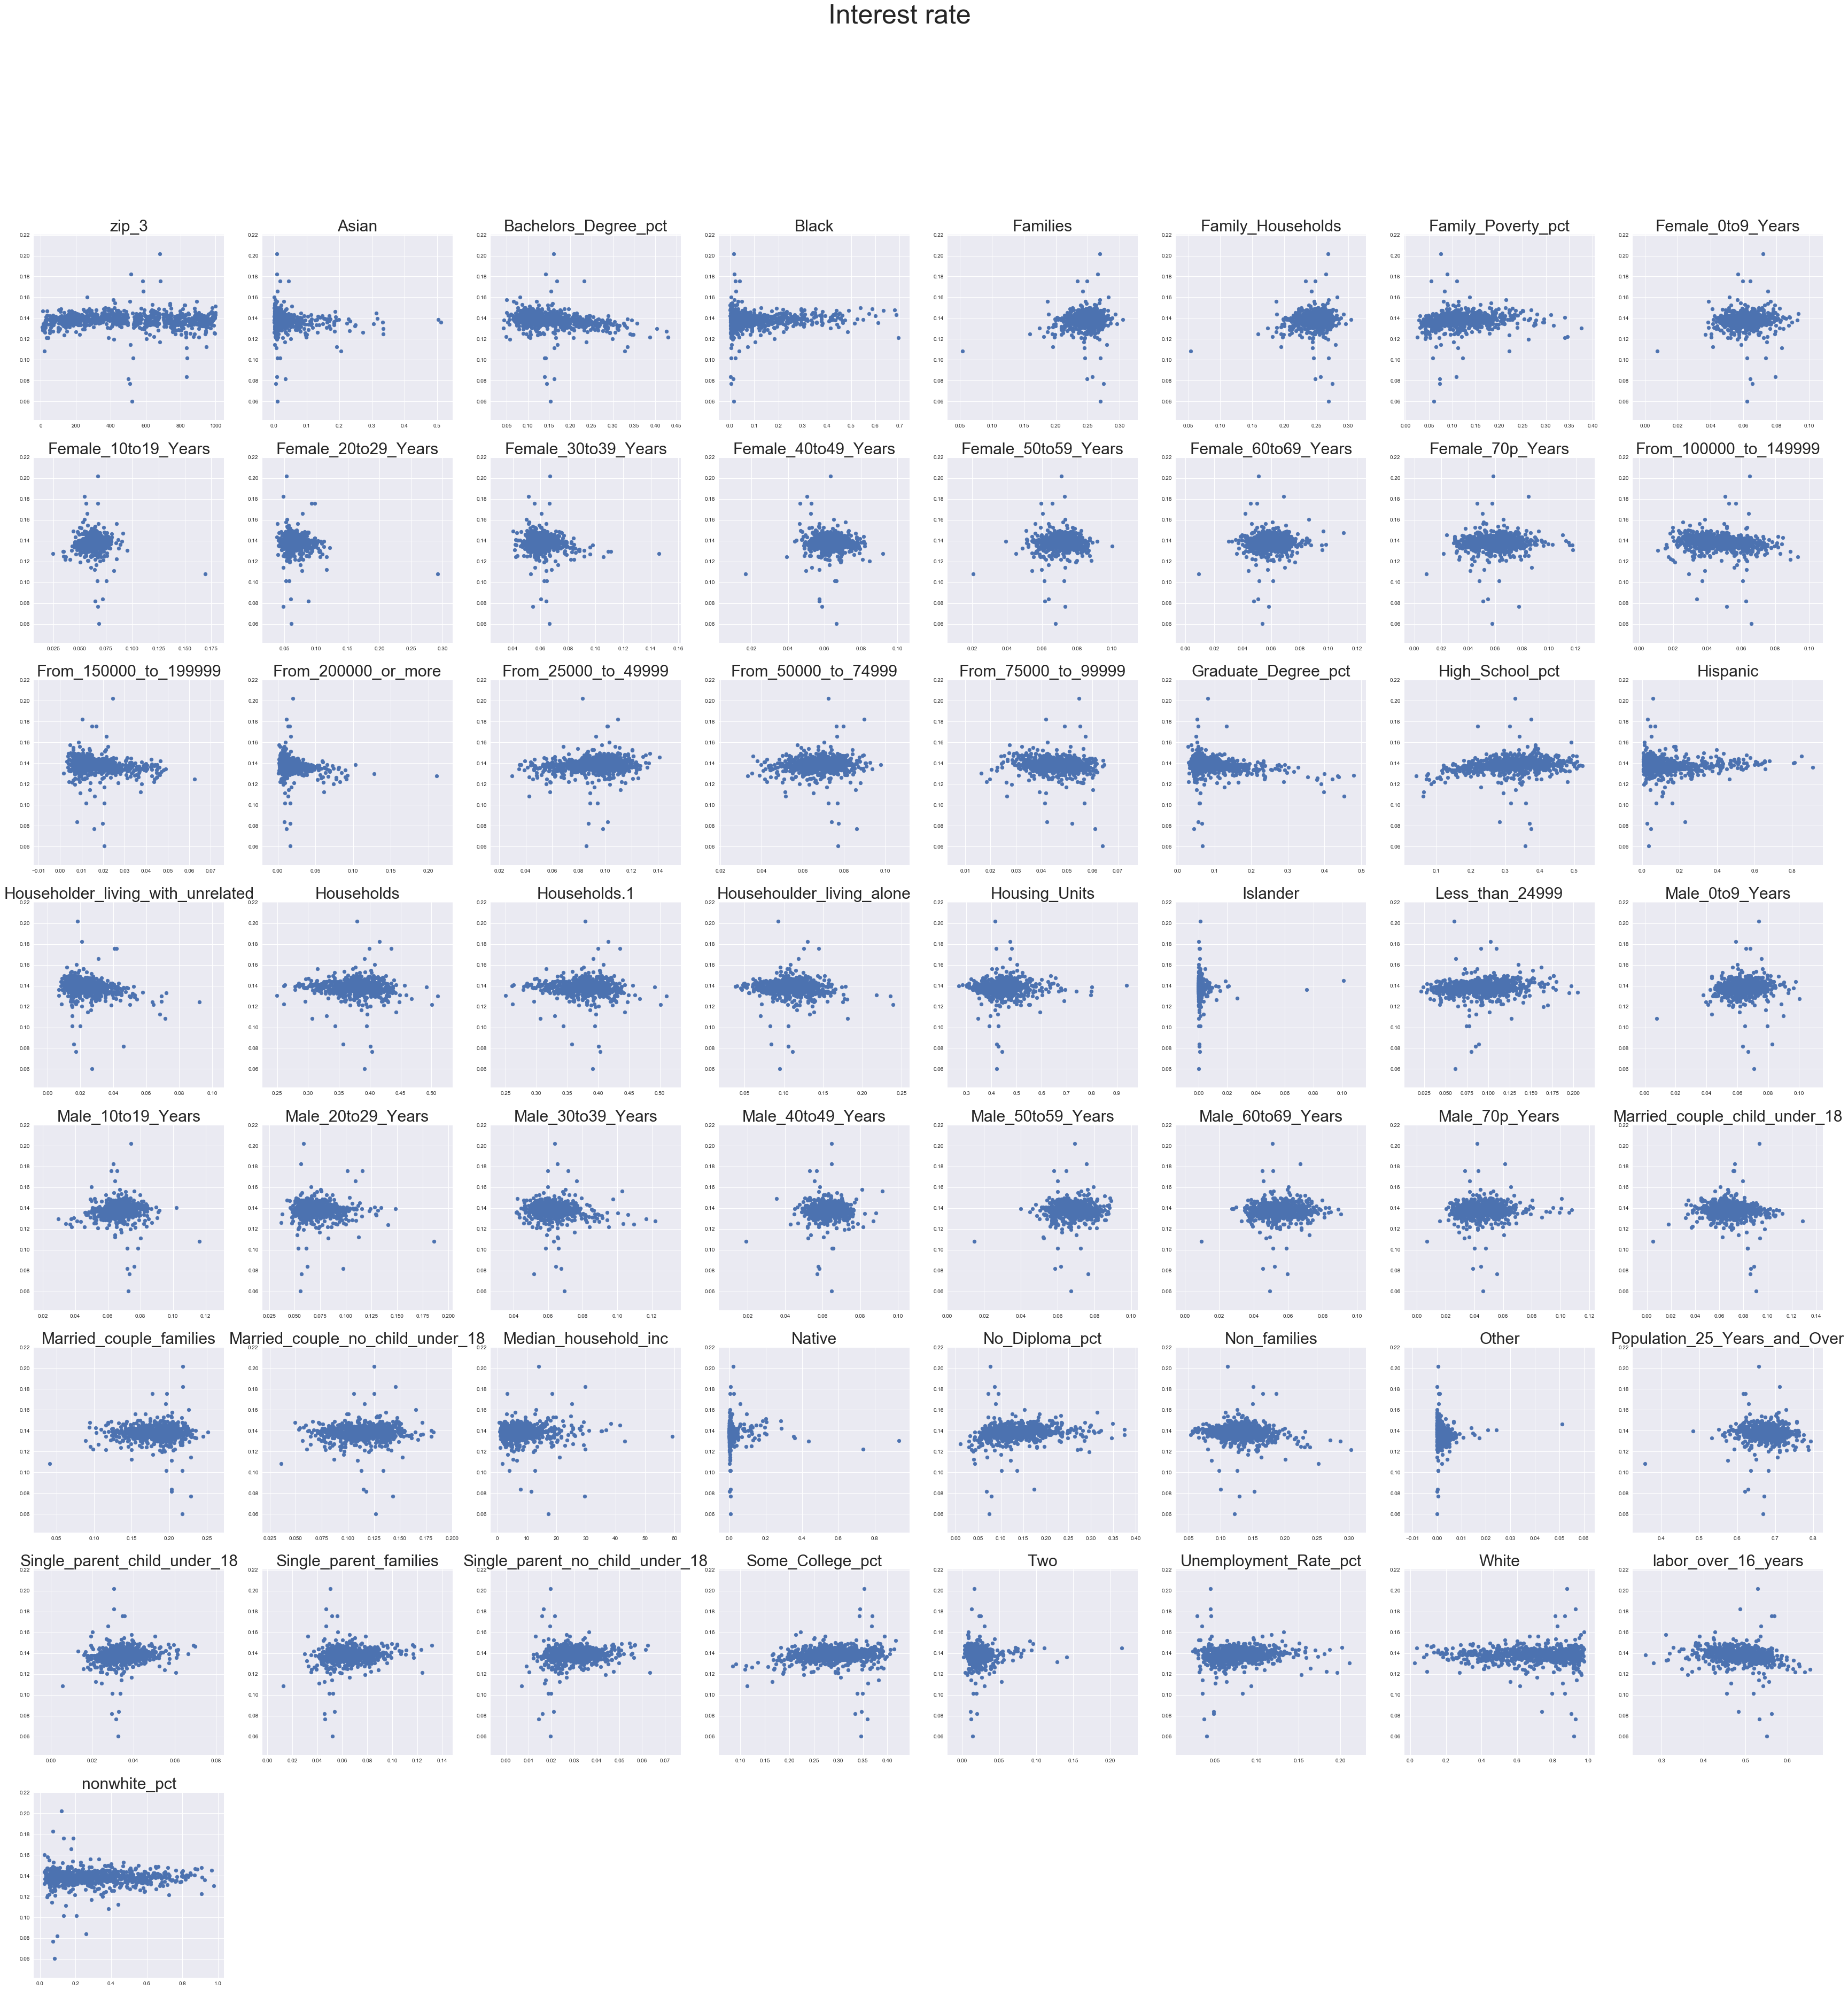

In [14]:
fig = plt.figure(figsize=(60,60))
for ind, col in enumerate(census3.columns):
    plt.subplot(8,8,ind+1)
    plt.title(col, fontsize=30)
    plt.scatter(lc_census_merged[col], lc_census_merged[('int_rate', 'mean')])
plt.suptitle('Interest rate',fontsize=50)

Text(0.5,0.98,'Loan amount')

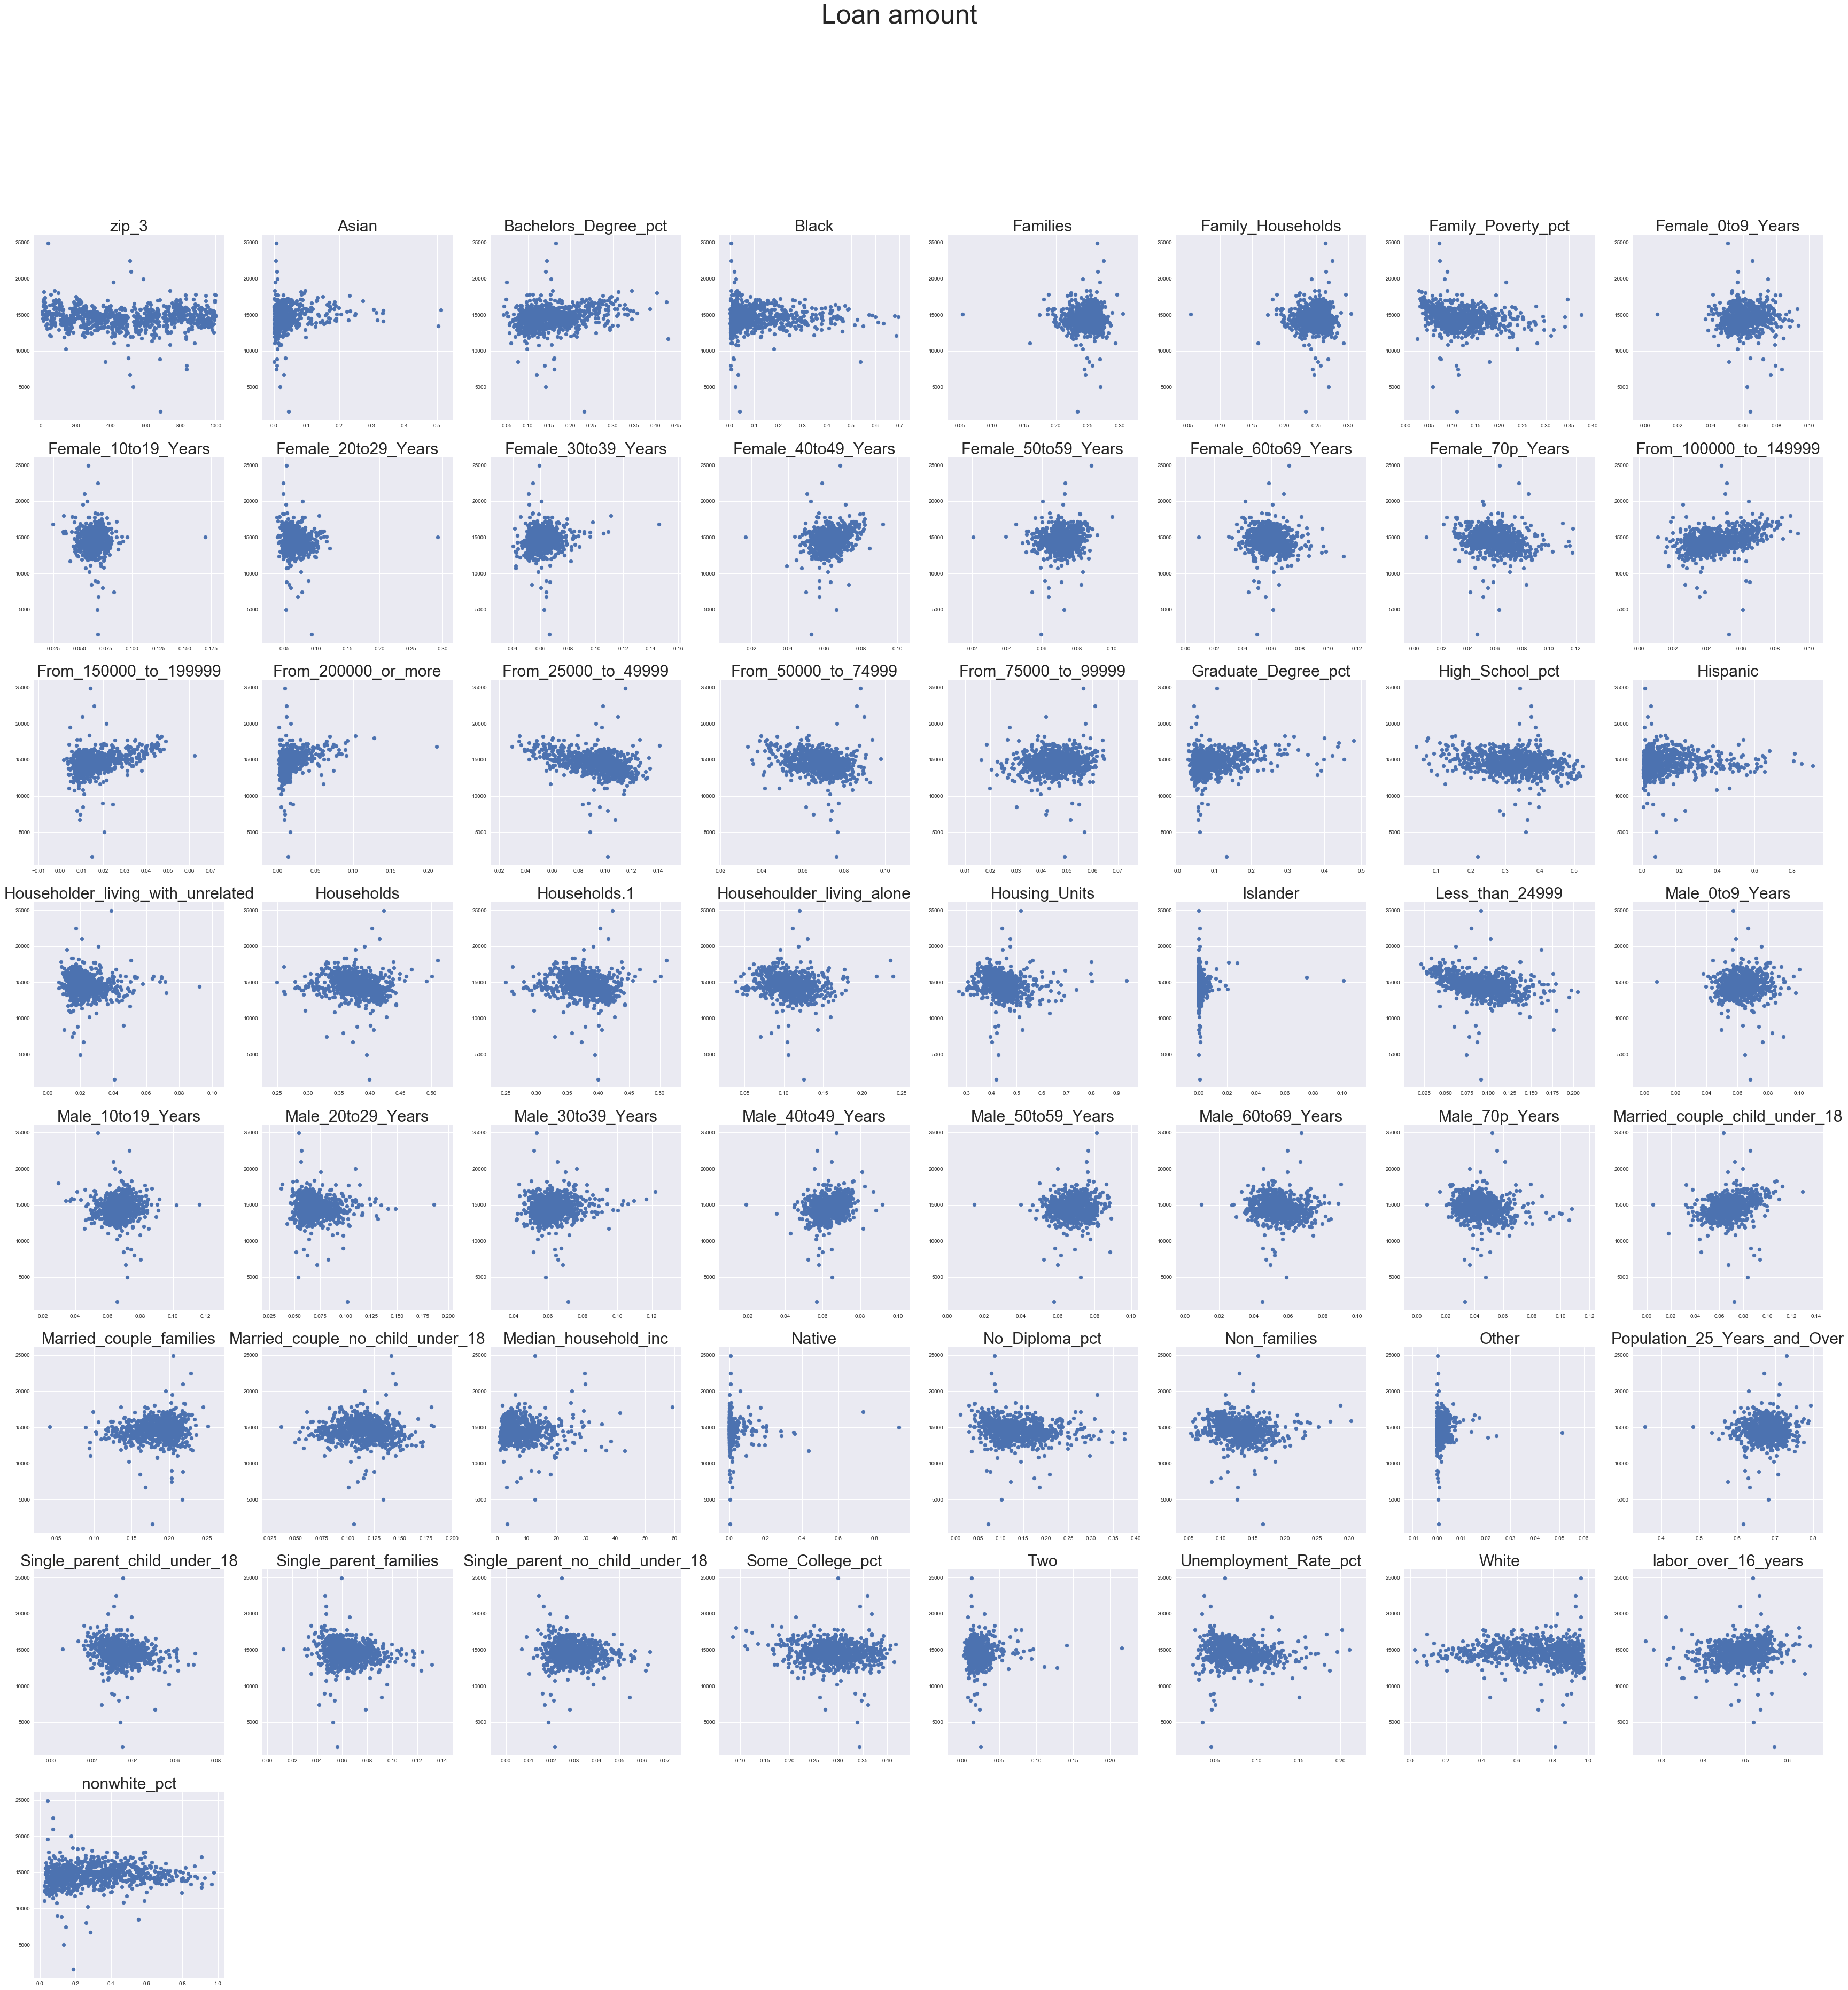

In [15]:
fig = plt.figure(figsize=(60,60))
for ind, col in enumerate(census3.columns):
    plt.subplot(8,8,ind+1)
    plt.title(col, fontsize=30)
    plt.scatter(lc_census_merged[col], lc_census_merged[('loan_amnt', 'mean')])
plt.suptitle('Loan amount',fontsize=50)

Text(0.5,0.98,'Debt-to-income ratio')

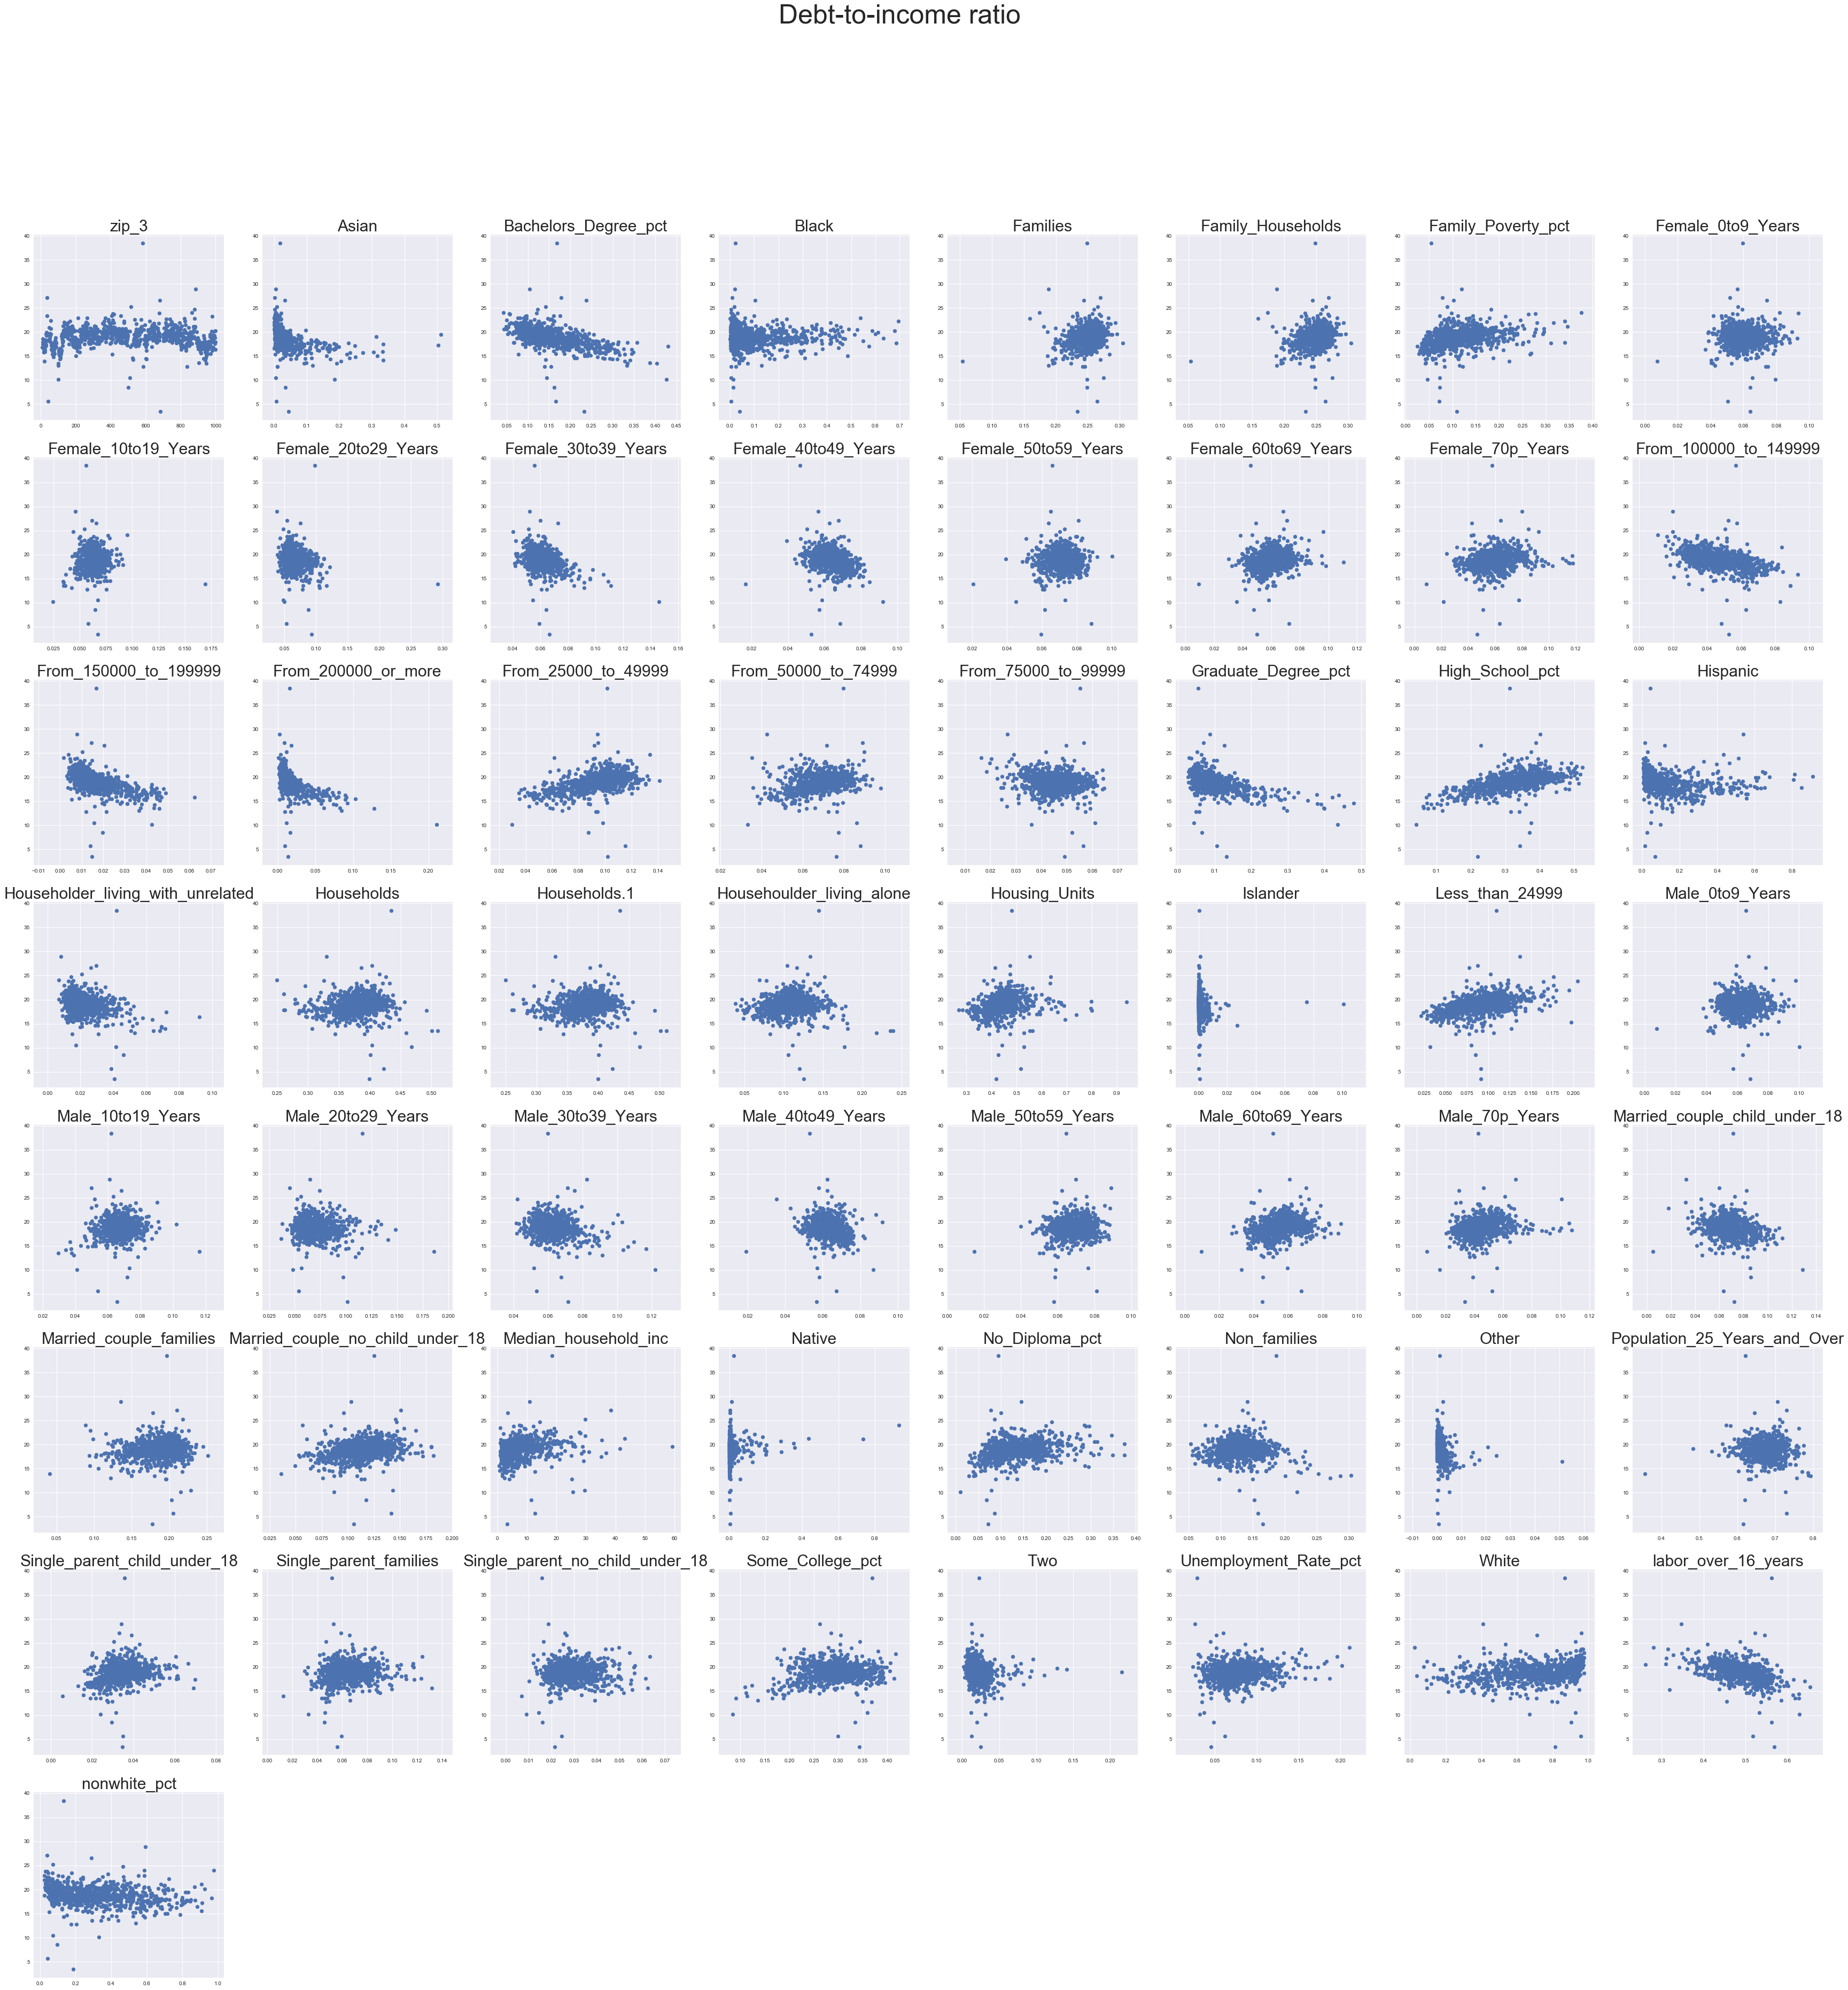

In [16]:
fig = plt.figure(figsize=(60,60))
for ind, col in enumerate(census3.columns):
    plt.subplot(8,8,ind+1)
    plt.title(col, fontsize=30)
    plt.scatter(lc_census_merged[col], lc_census_merged[('dti', 'mean')])
plt.suptitle('Debt-to-income ratio', fontsize=50)

Text(0.5,0.98,'How much available credit is drawn on')

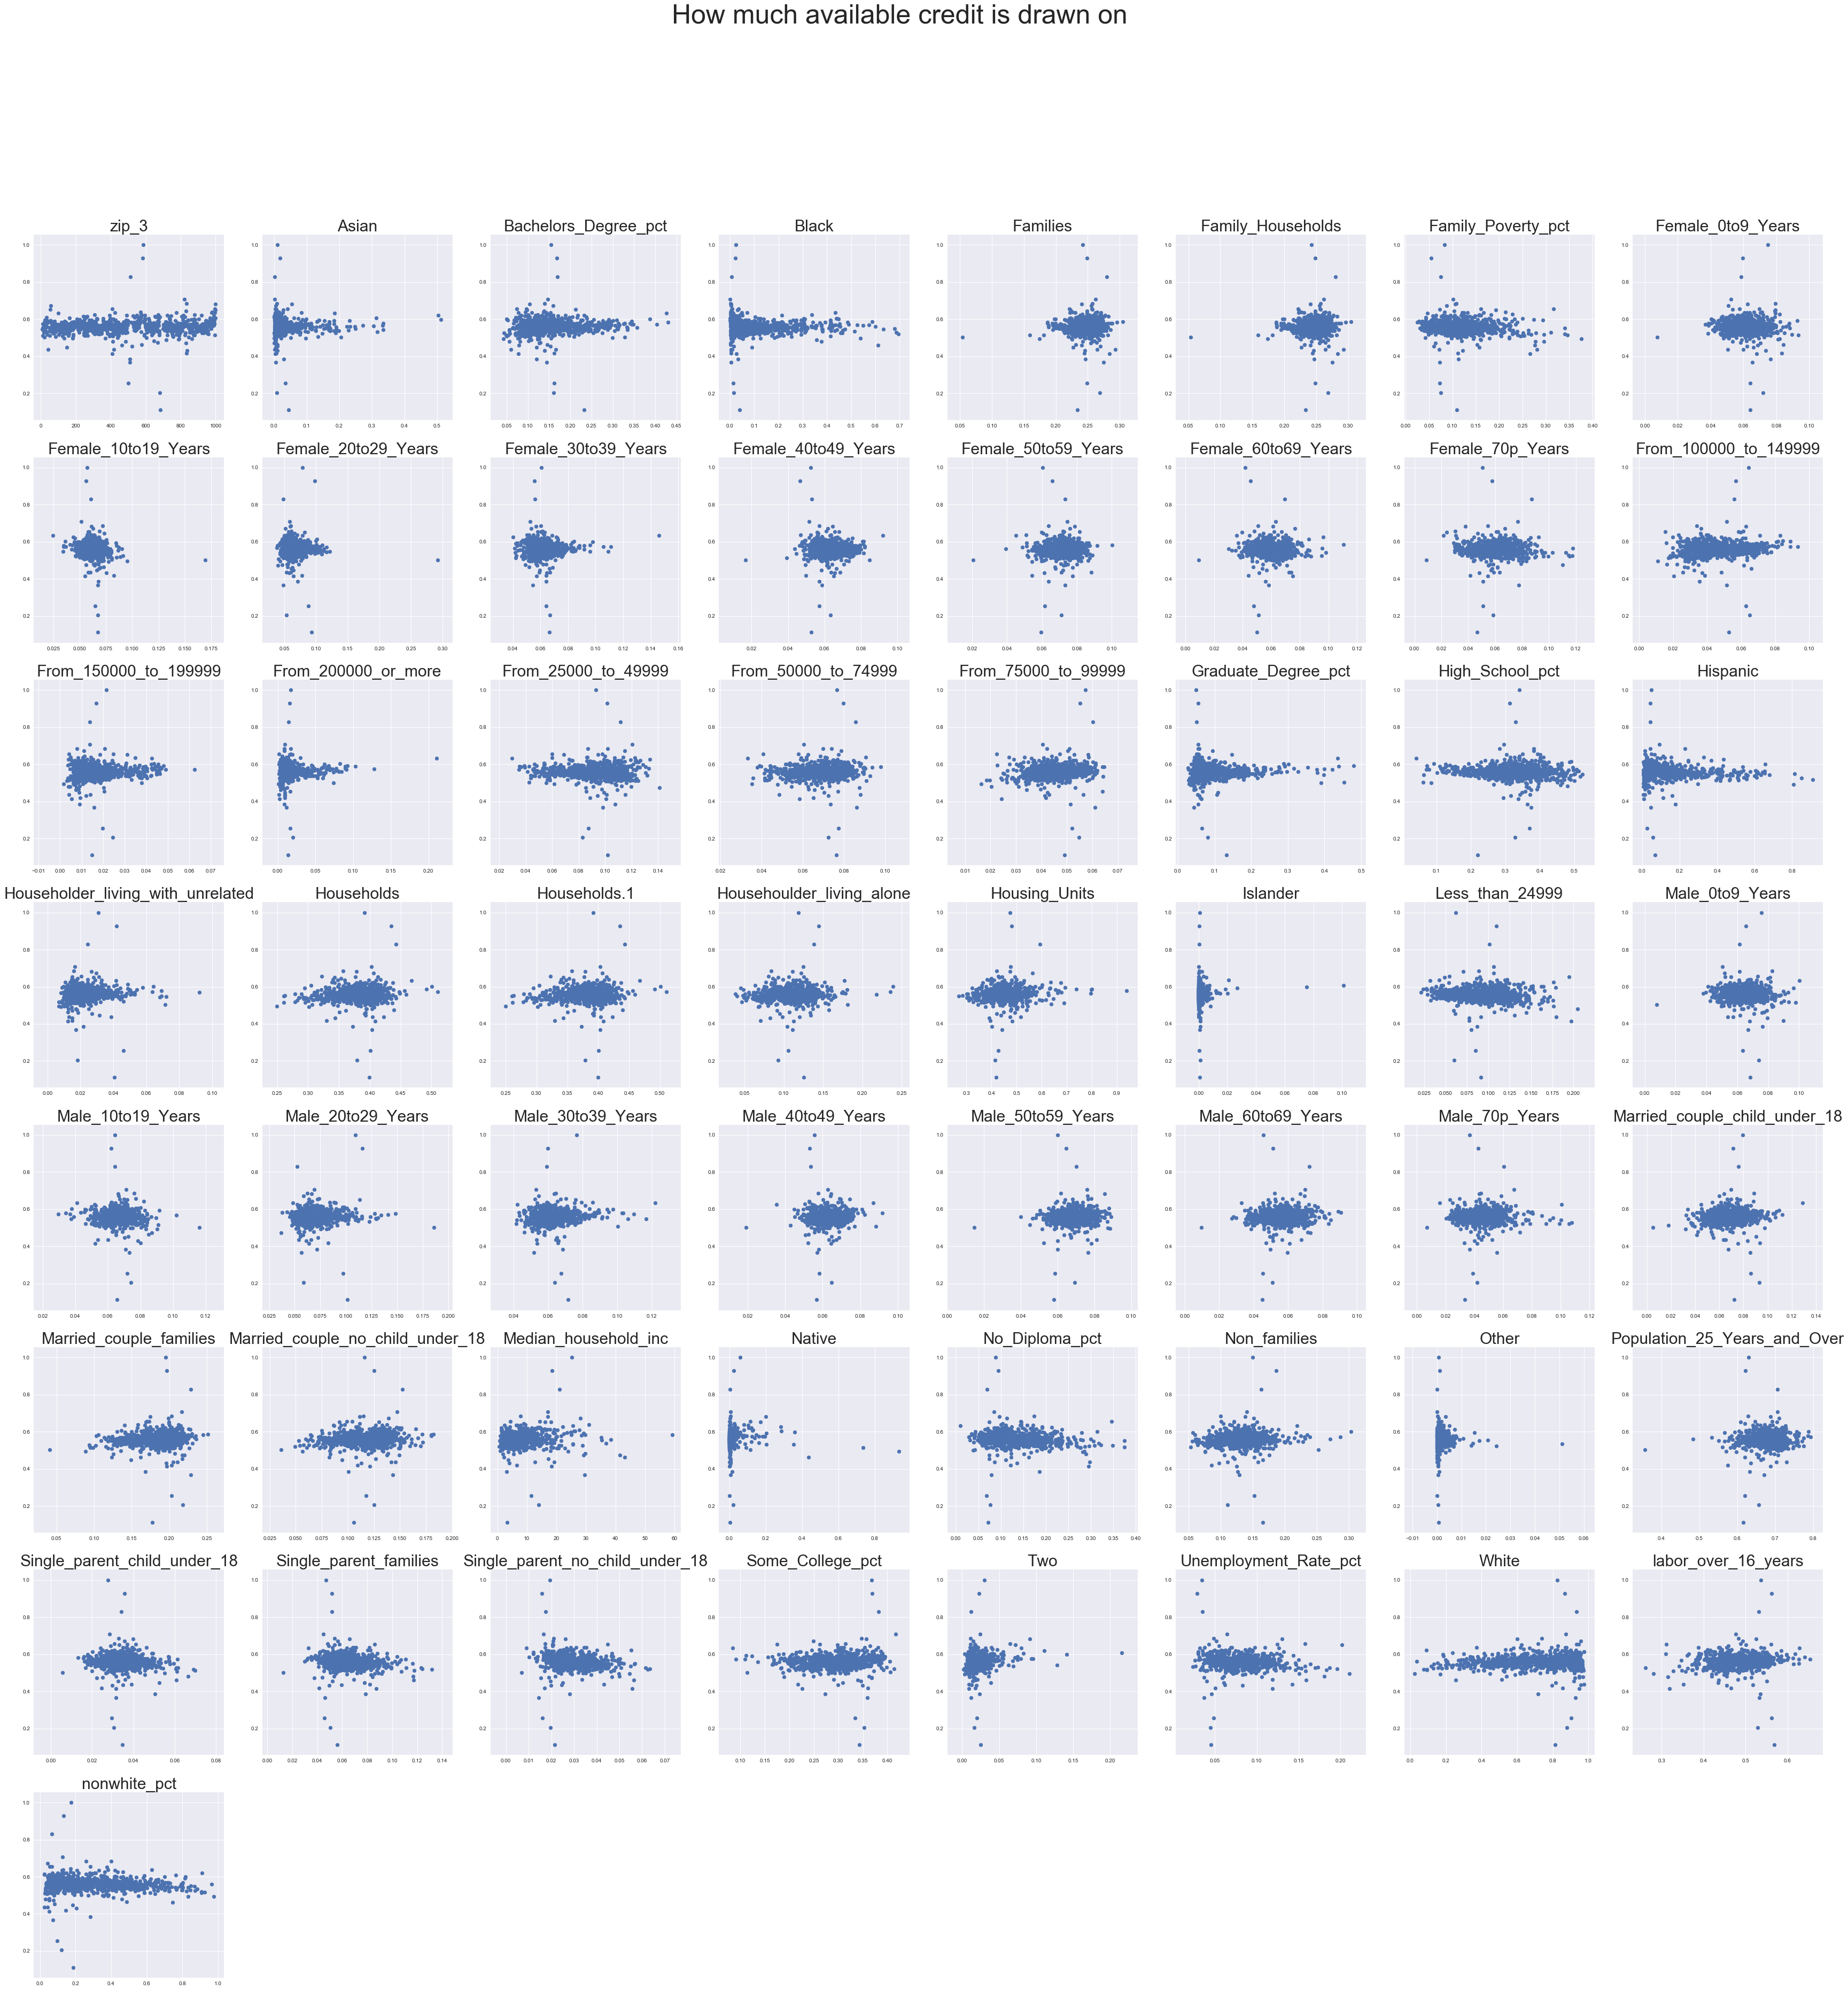

In [17]:
fig = plt.figure(figsize=(60,60))
for ind, col in enumerate(census3.columns):
    plt.subplot(8,8,ind+1)
    plt.title(col, fontsize=30)
    plt.scatter(lc_census_merged[col], lc_census_merged[('revol_util', 'mean')])
plt.suptitle('How much available credit is drawn on',fontsize=50)

# First cut at model

Initial model would be to regress these different LC variables on Census demographics at the 3-digit zip code level (for LC data, these variables are averaged at the 3-digit zip code level).

In [18]:
x_cols = ['Bachelors_Degree_pct','Family_Poverty_pct','Median_household_inc','nonwhite_pct','Unemployment_Rate_pct',
         'Single_parent_families','Households','Non_families','labor_over_16_years']
X = lc_census_merged[x_cols]
X = sm.add_constant(X)

In [19]:
loan_amnt_census_reg = OLS(lc_census_merged[('loan_amnt', 'mean')], X, missing='drop').fit()
loan_amnt_census_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     ('loan_amnt', 'mean')   R-squared:                       0.127
Model:                               OLS   Adj. R-squared:                  0.117
Method:                    Least Squares   F-statistic:                     13.33
Date:                   Thu, 06 Dec 2018   Prob (F-statistic):           4.57e-20
Time:                           01:42:37   Log-Likelihood:                -7286.2
No. Observations:                    837   AIC:                         1.459e+04
Df Residuals:                        827   BIC:                         1.464e+04
Df Model:                              9                                         
Covariance Type:               nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   1.254e+04   1539.522      8.145      0.000    9518.330    1.56e+04
Bachelors_Degree_pct    6465.0035   1562.106      4.139      0.000    3398.845    9531.162
Family_Poverty_pct     -3121.3672   2123.527     -1.470      0.142   -7289.504    1046.770
Median_household_inc      18.7040      9.517      1.965      0.050       0.023      37.385
nonwhite_pct            1394.8462    540.968      2.578      0.010     333.015    2456.678
Unemployment_Rate_pct   5168.6492   3046.815      1.696      0.090    -811.750    1.11e+04
Single_parent_families -1.117e+04   7202.493     -1.550      0.121   -2.53e+04    2971.346
Households              9833.7804   4475.287      2.197      0.028    1049.523    1.86e+04
Non_families           -1.693e+04   3859.264     -4.388      0.000   -2.45e+04   -9357.836
labor_over_16_years     -698.7063   1795.498     -0.389      0.697   -4222.975    2825.563
==============================================================================
Omnibus:                      296.283   Durbin-Watson:                   1.785
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8312.153
Skew:                          -0.988   Prob(JB):                         0.00
Kurtosis:                      18.311   Cond. No.                     1.57e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.57e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [20]:
int_rate_census_reg = OLS(lc_census_merged[('int_rate', 'mean')], X, missing='drop').fit()
int_rate_census_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     ('int_rate', 'mean')   R-squared:                       0.092
Model:                              OLS   Adj. R-squared:                  0.082
Method:                   Least Squares   F-statistic:                     9.338
Date:                  Thu, 06 Dec 2018   Prob (F-statistic):           1.36e-13
Time:                          01:42:37   Log-Likelihood:                 2880.5
No. Observations:                   837   AIC:                            -5741.
Df Residuals:                       827   BIC:                            -5694.
Df Model:                             9                                         
Covariance Type:              nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.1305      0.008     15.970      0.000       0.114       0.147
Bachelors_Degree_pct      -0.0374      0.008     -4.509      0.000      -0.054      -0.021
Family_Poverty_pct        -0.0184      0.011     -1.636      0.102      -0.041       0.004
Median_household_inc   -1.066e-05   5.05e-05     -0.211      0.833      -0.000    8.85e-05
nonwhite_pct               0.0053      0.003      1.863      0.063      -0.000       0.011
Unemployment_Rate_pct     -0.0032      0.016     -0.199      0.842      -0.035       0.029
Single_parent_families     0.0611      0.038      1.600      0.110      -0.014       0.136
Households                 0.0464      0.024      1.954      0.051      -0.000       0.093
Non_families              -0.0453      0.020     -2.211      0.027      -0.085      -0.005
labor_over_16_years       -0.0025      0.010     -0.258      0.797      -0.021       0.016
==============================================================================
Omnibus:                      467.659   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            34009.144
Skew:                          -1.682   Prob(JB):                         0.00
Kurtosis:                      34.046   Cond. No.                     1.57e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.57e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

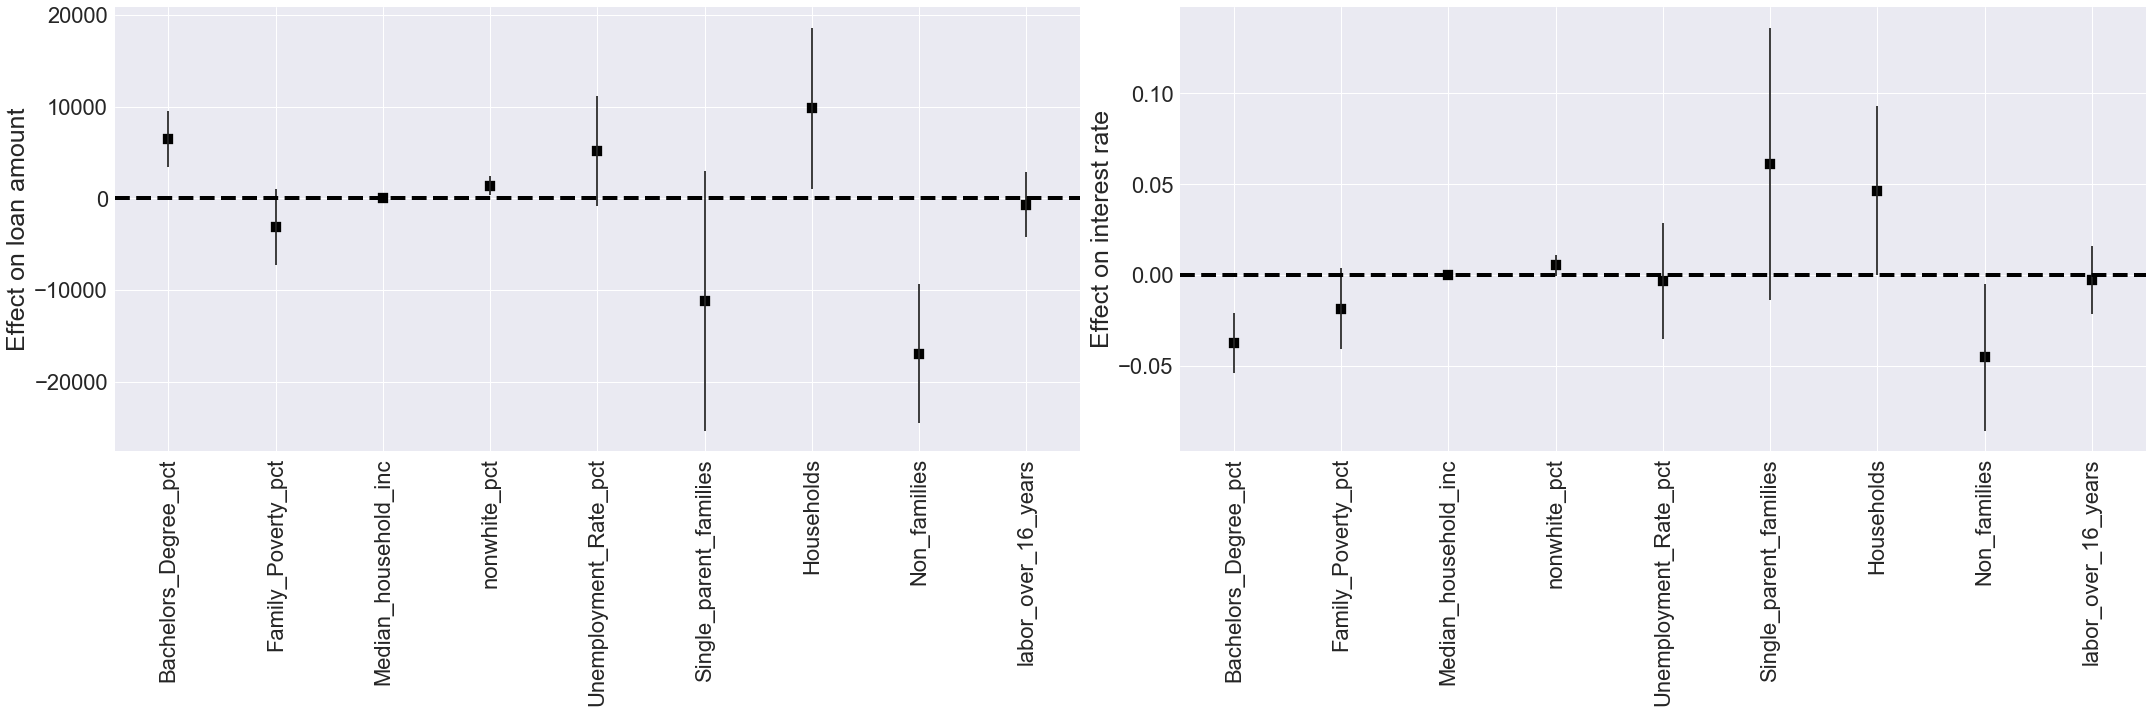

In [21]:
fig, ax = plt.subplots(1,2,figsize=(30, 10))

# loan_amnt
err_loan_amnt = loan_amnt_census_reg.params - loan_amnt_census_reg.conf_int()[0]
coef_loan_amnt = pd.DataFrame({'coef': loan_amnt_census_reg.params.values[1:],
                        'err': err_loan_amnt.values[1:],
                        'varname': err_loan_amnt.index.values[1:]
                       })

coef_loan_amnt.plot(x='varname', y='coef', kind='bar', 
             ax=ax[0], color='none', 
             yerr='err', legend=False)
ax[0].set_ylabel('Effect on loan amount', fontsize=25)
ax[0].set_xlabel('')
ax[0].scatter(x=pd.np.arange(coef_loan_amnt.shape[0]), 
           marker='s', s=120, 
           y=coef_loan_amnt['coef'], color='black')
ax[0].axhline(y=0, linestyle='--', color='black', linewidth=4)
ax[0].xaxis.set_ticks_position('none')
ax[0].tick_params(axis='both', which='major', labelsize=22)

err_int_rate = int_rate_census_reg.params - int_rate_census_reg.conf_int()[0]
coef_int_rate = pd.DataFrame({'coef': int_rate_census_reg.params.values[1:],
                        'err': err_int_rate.values[1:],
                        'varname': err_int_rate.index.values[1:]
                       })

# int_rate
coef_int_rate.plot(x='varname', y='coef', kind='bar', 
             ax=ax[1], color='none', 
             yerr='err', legend=False)
ax[1].set_ylabel('Effect on interest rate', fontsize=25)
ax[1].set_xlabel('')
ax[1].scatter(x=pd.np.arange(coef_int_rate.shape[0]), 
           marker='s', s=120, 
           y=coef_int_rate['coef'], color='black')
ax[1].axhline(y=0, linestyle='--', color='black', linewidth=4)
ax[1].xaxis.set_ticks_position('none')
ax[1].tick_params(axis='both', which='major', labelsize=22)

plt.tight_layout()
plt.savefig('baseline_discrim_model_coefs.png')

# Incorporate Reject Stats 

Using data from 2013-2014 because the LC data I've been using above is from 2014. First, going to have to reformat LC rejected data like I did LC accepted data.

In [22]:
lc_reject_all['zip_code'] = lc_reject_all['Zip Code'].str.slice(0,3)
lc_reject_all['Debt-To-Income Ratio'] = lc_reject_all['Debt-To-Income Ratio'].map(format_percents, na_action='ignore')

In [23]:
print('Number of unique 3-digit zip codes in the rejected stats:',len(set(lc_reject_all['Zip Code'])))

Number of unique 3-digit zip codes in the rejected stats: 998


This is strange. For now I'll do a left join with the accepted data as the base table since it had less than 929, which is apprently the number of 3 digit zip codes in the USA ([source](https://healthyalgorithms.com/2015/02/13/how-many-3-digit-zip-codes-are-there/)).

In [24]:
lc_zip3_count = pd.DataFrame(lc_all.groupby('zip_code').count()['index'])
lc_zip3_count.columns = ['num_accepted']
lc_reject_zip3_count = pd.DataFrame(lc_reject_all.groupby('zip_code').count()['index'])
lc_reject_zip3_count.columns = ['num_rejected']

In [25]:
lc_zip3_count_merged = lc_zip3_count.merge(lc_reject_zip3_count, 'left', left_on='zip_code', right_on='zip_code').reset_index()
lc_zip3_count_census_merged = lc_zip3_count_merged.merge(census3, 'left', left_on='zip_code', right_on='zip_3').reset_index()


In [26]:
lc_zip3_count_census_merged['pct_accepted'] = lc_zip3_count_merged.num_accepted/lc_zip3_count_census_merged.num_rejected
lc_zip3_count_census_merged['num_loan_apps_considered'] = lc_zip3_count_merged.num_accepted+lc_zip3_count_census_merged.num_rejected


In [27]:
# just using reject data, see if people in same zip codes with different dti, risk scores, employment lengths are rejected differently
# histograms for dti and risk score and bar charts for employment

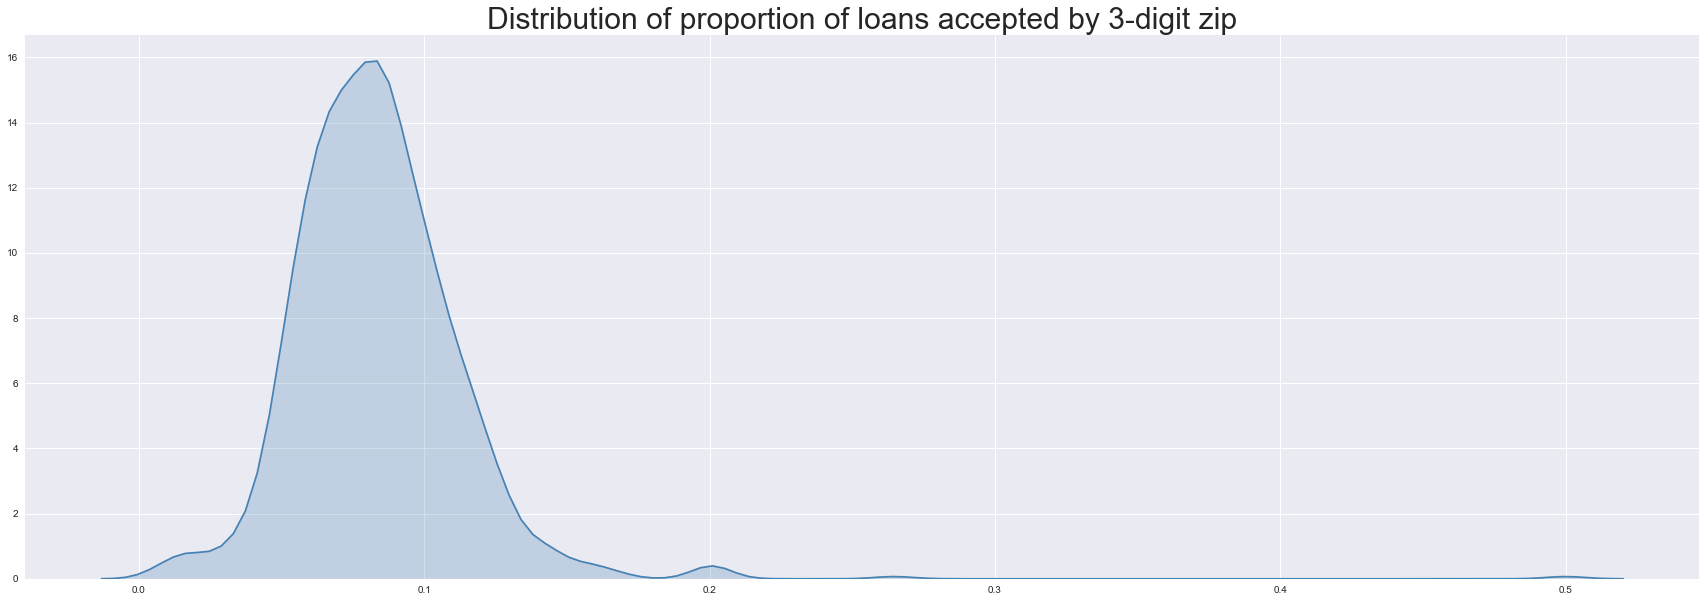

In [28]:
plt.figure(figsize=(30,10))
sns.kdeplot(lc_zip3_count_census_merged.pct_accepted.dropna(), shade=True, color='steelblue', legend=False)
plt.title('Distribution of proportion of loans accepted by 3-digit zip', fontsize=30)
plt.show()

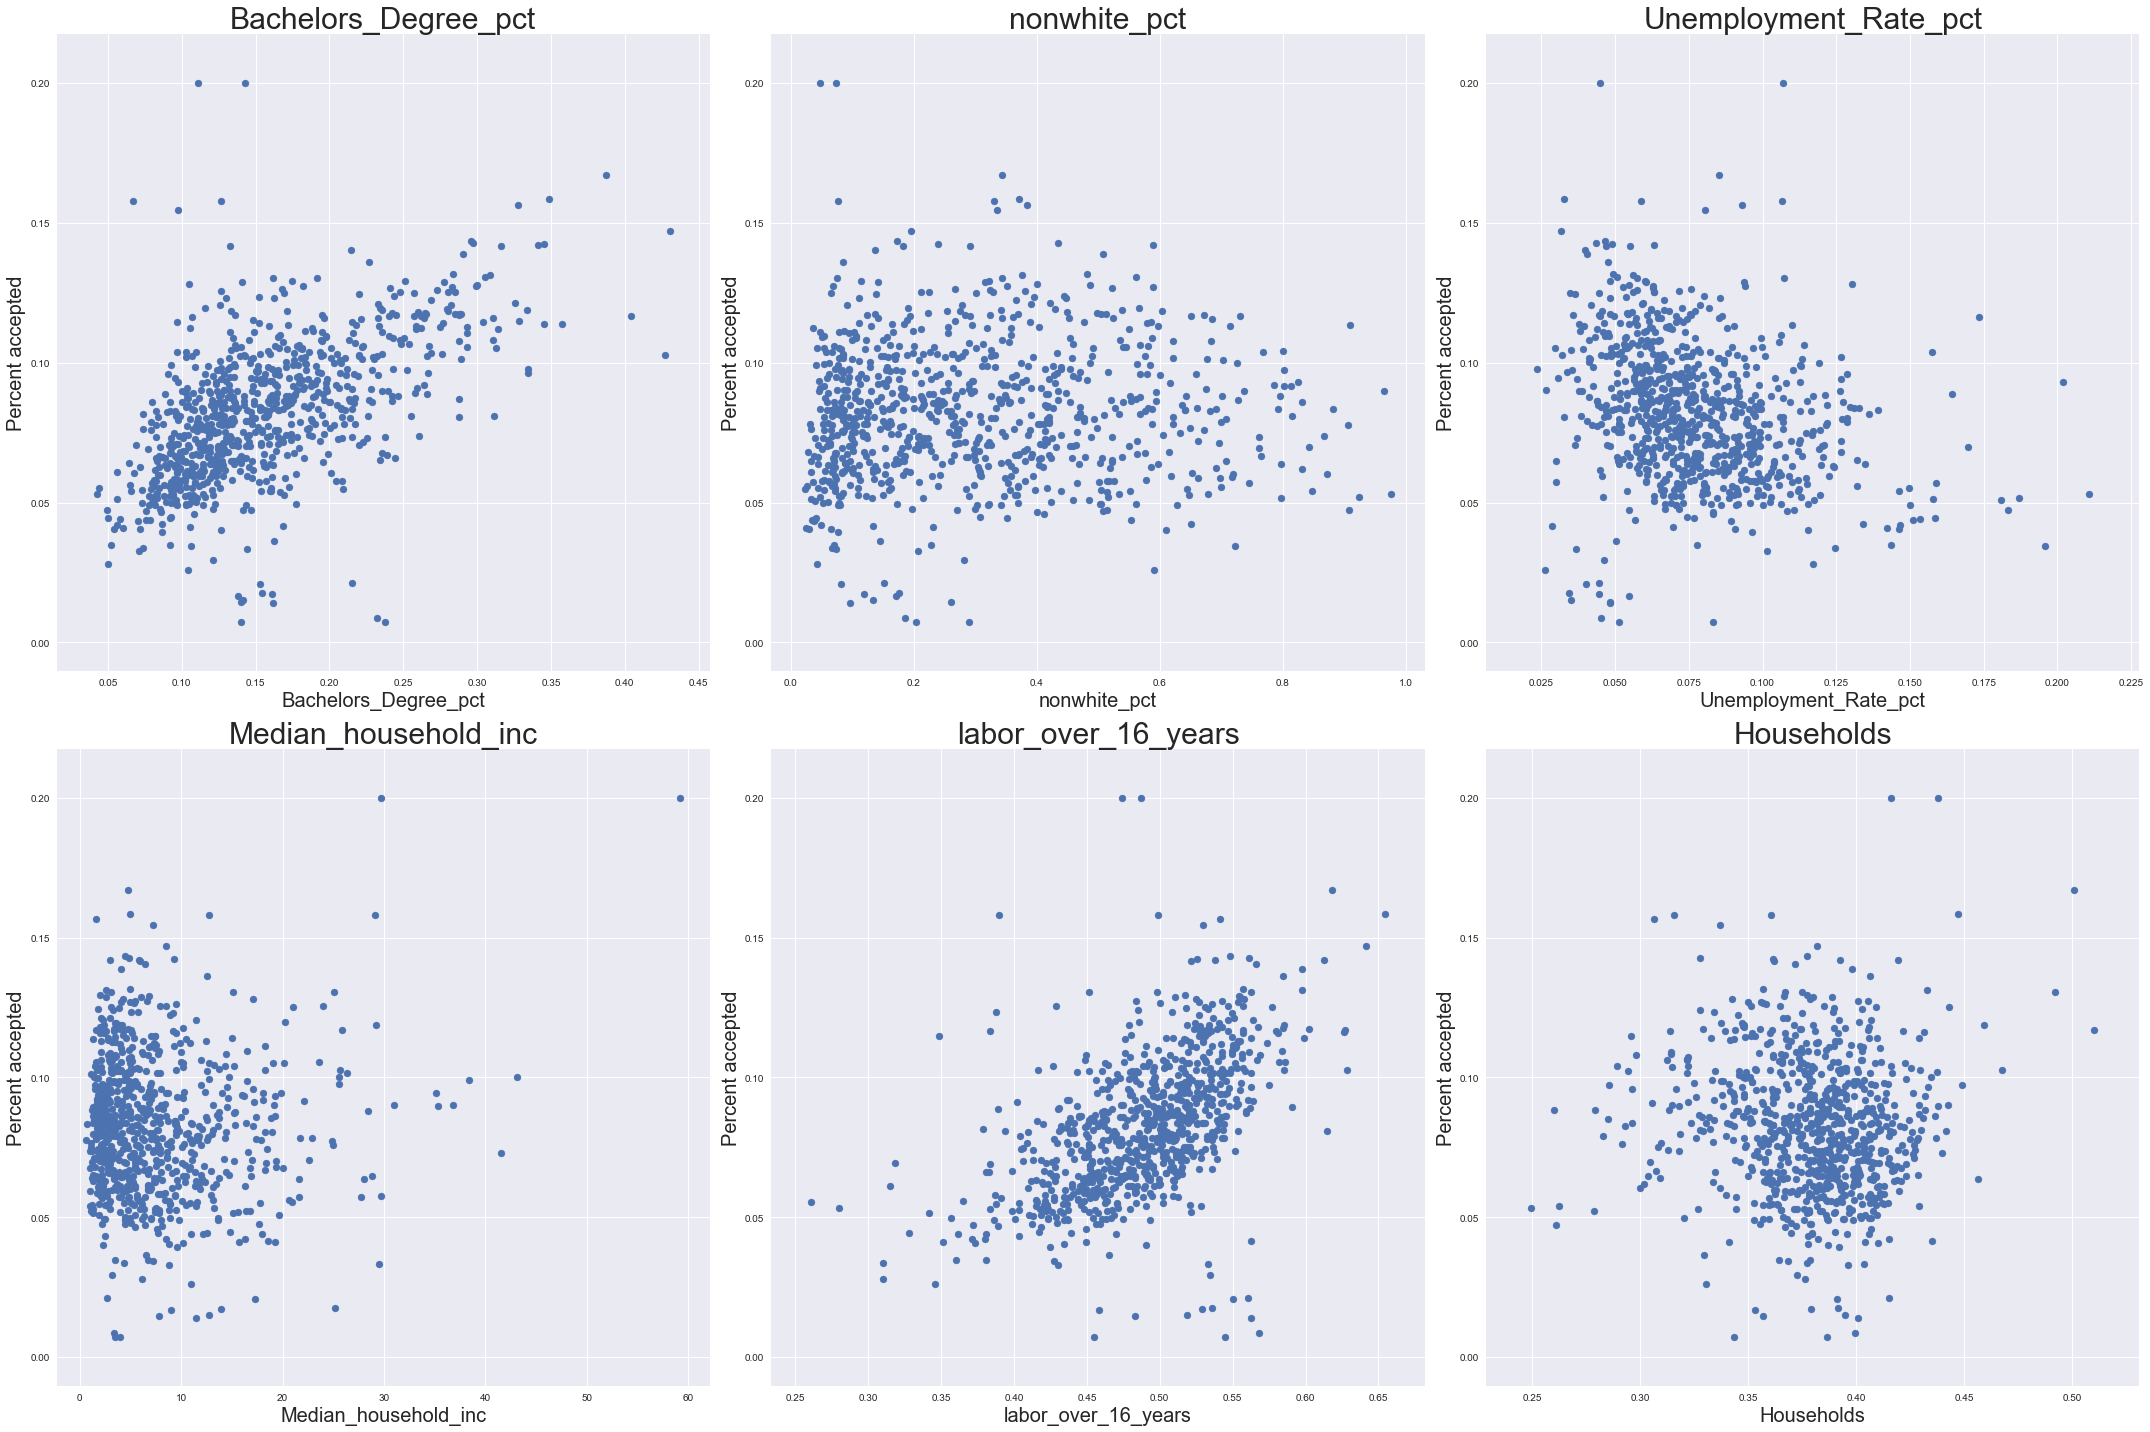

In [29]:
cols_for_scatter = ['Bachelors_Degree_pct','nonwhite_pct','Unemployment_Rate_pct', 'Median_household_inc',
                   'labor_over_16_years','Households']
fig = plt.figure(figsize=(30,20));
for i, col in enumerate(cols_for_scatter):
    ax = plt.subplot(2,3,i+1)
    ax.scatter(lc_zip3_count_census_merged[col], lc_zip3_count_census_merged.pct_accepted)
    ax.set_ylabel('Percent accepted', fontsize=20)
    ax.set_xlabel(col, fontsize=20)
    ax.set_title(col, fontsize=30)
    
plt.tight_layout()
plt.savefig('census_demos_v_pct_accepted.png')

In [30]:
# OLS: pct_accepted ~ demographics
X = lc_zip3_count_census_merged[x_cols]
X = sm.add_constant(X)

pct_accepted_census_reg = OLS(lc_zip3_count_census_merged.pct_accepted, X, missing='drop').fit()

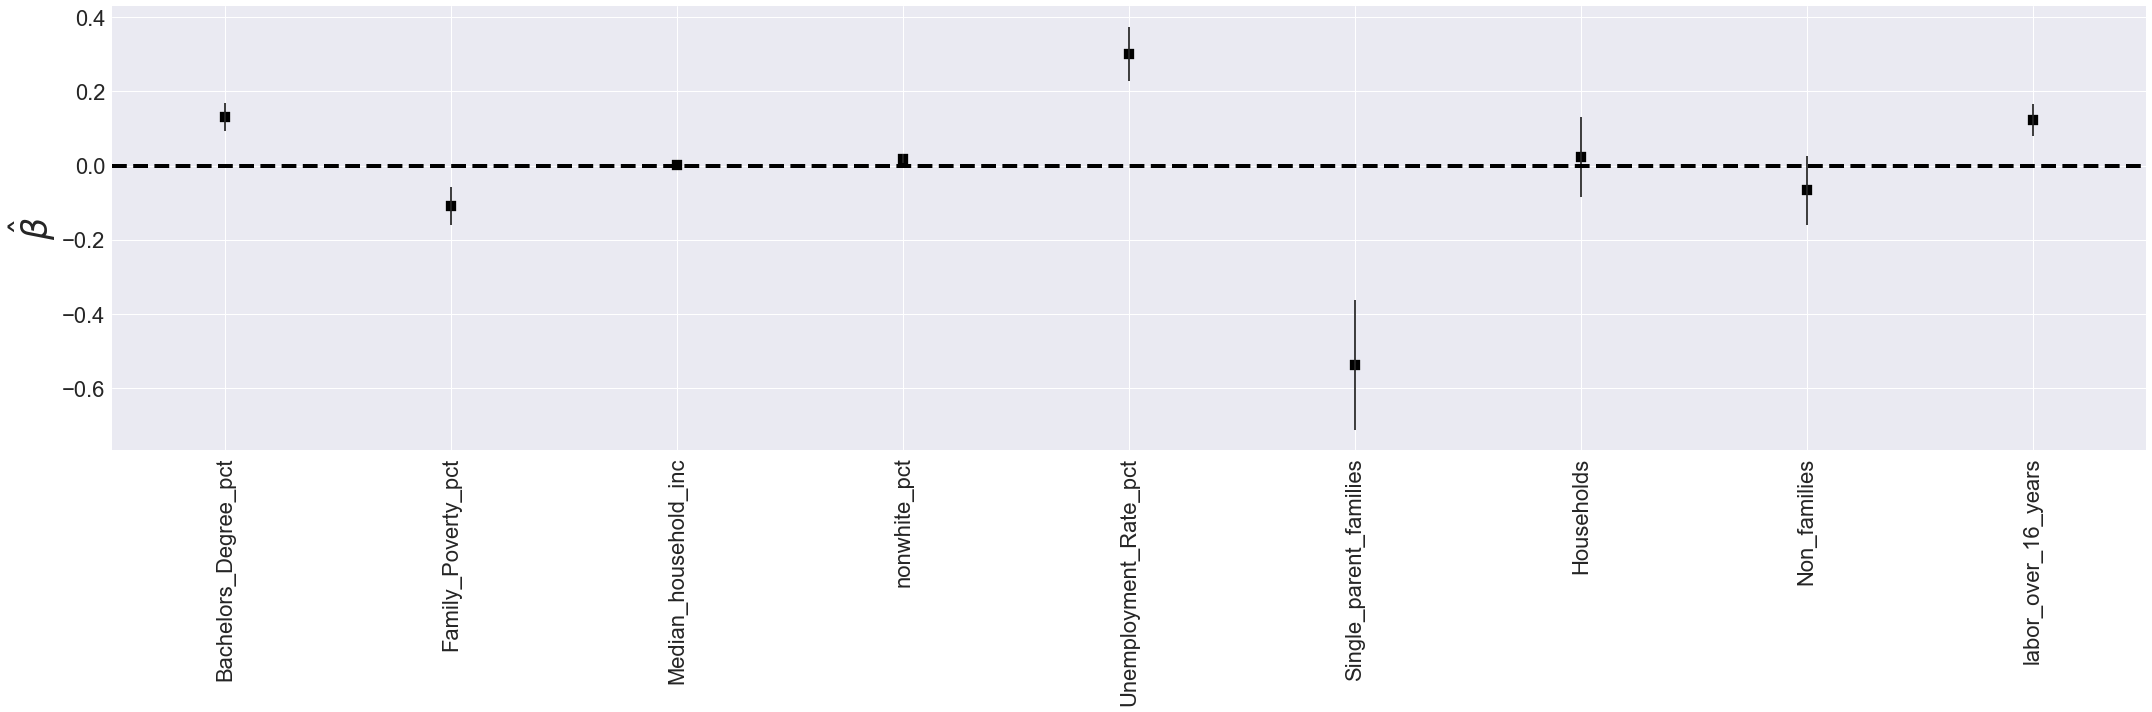

In [31]:
fig, ax = plt.subplots(figsize=(30, 10))

err_pct_accepted = pct_accepted_census_reg.params - pct_accepted_census_reg.conf_int()[0]
coef_pct_accepted = pd.DataFrame({'coef': pct_accepted_census_reg.params.values[1:],
                        'err': err_pct_accepted.values[1:],
                        'varname': err_pct_accepted.index.values[1:]
                       })

coef_pct_accepted.plot(x='varname', y='coef', kind='bar', 
             ax=ax, color='none', 
             yerr='err', legend=False)
ax.set_ylabel(r'$\hat{\beta}$', fontsize=35)
ax.set_xlabel('')
ax.scatter(x=pd.np.arange(coef_pct_accepted.shape[0]), 
           marker='s', s=120, 
           y=coef_pct_accepted['coef'], color='black')
ax.axhline(y=0, linestyle='--', color='black', linewidth=4)
ax.xaxis.set_ticks_position('none')
ax.tick_params(axis='both', which='major', labelsize=22)

plt.tight_layout()
plt.savefig('pct_accepted_census_demos_coefs.png')

In [32]:
# save data
lc_zip3_count_census_merged[['zip_code','pct_accepted','num_loan_apps_considered']].to_csv('../data/2014_loan_data/pct_accepted_by_zip3_2014.csv', index=False)
lc_zip3_count_census_merged.to_csv('../data/2014_loan_data/pct_accepted_by_zip3_2014_ALL.csv', index=False)


# Let's do this for the loans our ROI model says to take

In [52]:
buy15 = pd.read_csv('../hugo/loans_bought_2015', dtype={'ZIP':str})

In [53]:
print('Number of loans we recommend:',buy15.shape[0])

Number of loans we recommend: 1726


In [54]:
buy15_census = buy15.merge(lc_zip3_count_census_merged, 'left', left_on='ZIP', right_on='zip_3')

In [68]:
# OLS: pct_accepted ~ demographics for our selected loans
X = buy15_census[x_cols]
X = sm.add_constant(X)

pct_accepted_census_reg_selected = OLS(buy15_census.pct_accepted_x, X, missing='drop').fit()

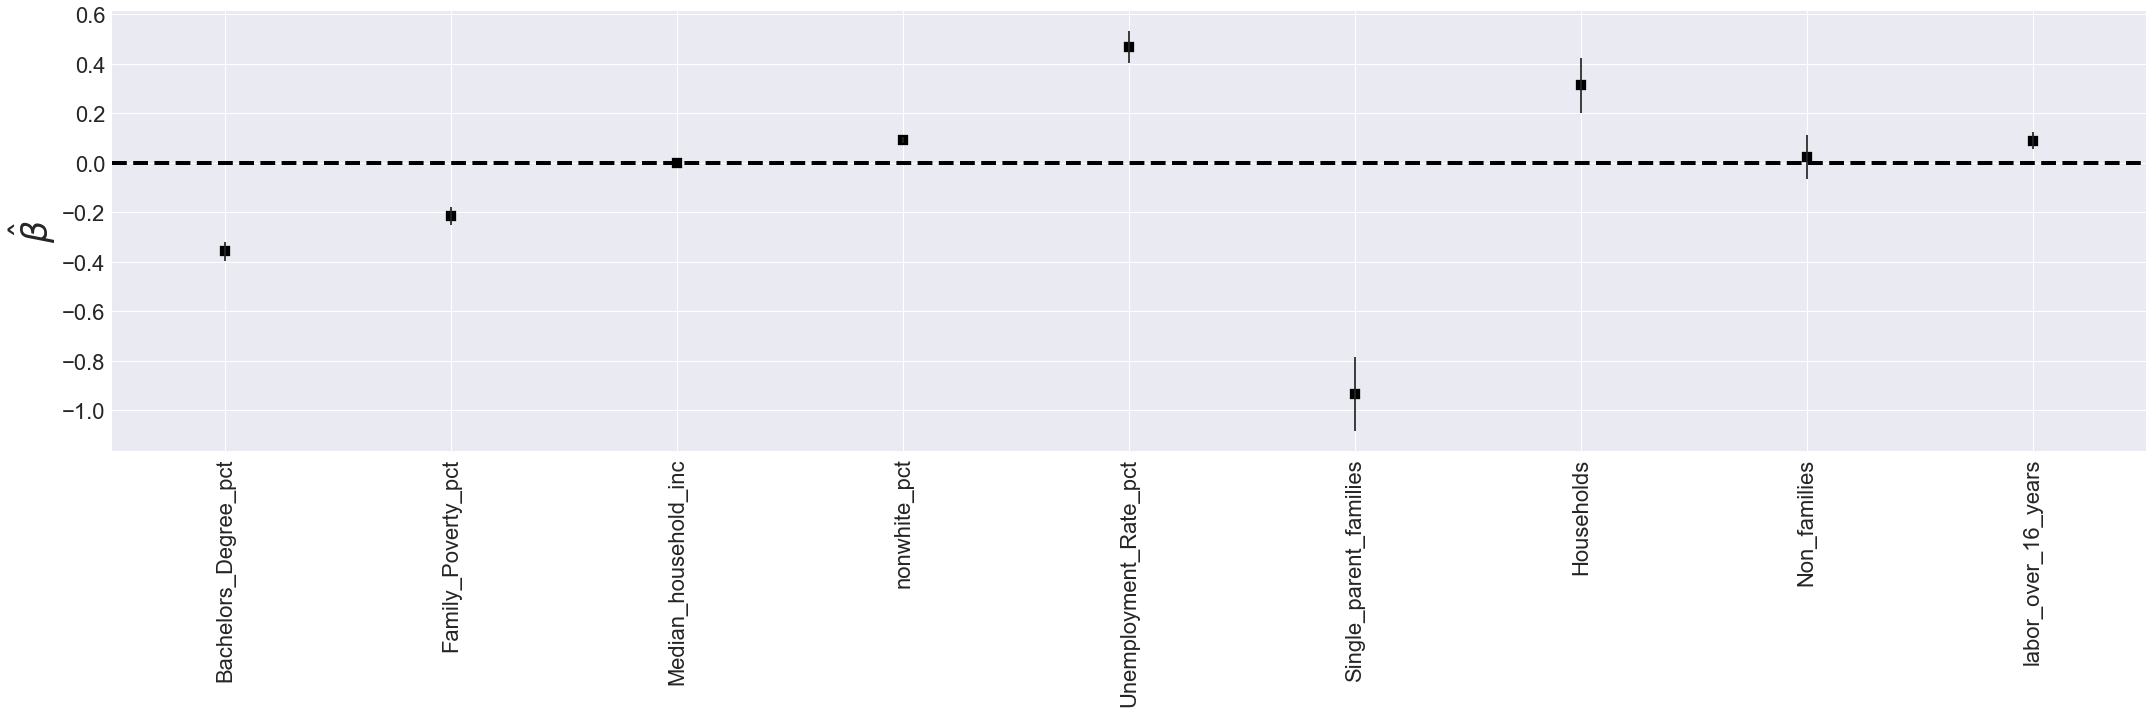

In [70]:
fig, ax = plt.subplots(figsize=(30, 10))

err_pct_accepted_selected = pct_accepted_census_reg_selected.params - pct_accepted_census_reg_selected.conf_int()[0]
coef_pct_accepted_selected = pd.DataFrame({'coef': pct_accepted_census_reg_selected.params.values[1:],
                        'err': err_pct_accepted_selected.values[1:],
                        'varname': err_pct_accepted_selected.index.values[1:]
                       })

coef_pct_accepted_selected.plot(x='varname', y='coef', kind='bar', 
             ax=ax, color='none', 
             yerr='err', legend=False)
ax.set_ylabel(r'$\hat{\beta}$', fontsize=35)
ax.set_xlabel('')
ax.scatter(x=pd.np.arange(coef_pct_accepted_selected.shape[0]), 
           marker='s', s=120, 
           y=coef_pct_accepted_selected['coef'], color='black')
ax.axhline(y=0, linestyle='--', color='black', linewidth=4)
ax.xaxis.set_ticks_position('none')
ax.tick_params(axis='both', which='major', labelsize=22)

plt.tight_layout()
plt.savefig('pct_accepted__selected_loancensus_demos_coefs.png')